In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mne
import pandas as pd
from scipy.io import loadmat

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import cross_val_score, GridSearchCV, LeaveOneOut
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline

from pyriemann.classification import MDM, FgMDM, TSclassifier
from pyriemann.estimation import Covariances
from pyriemann.tangentspace import TangentSpace

from mne.decoding import CSP
from tqdm.notebook import trange, tqdm

%matplotlib inline

In [2]:
scoring = 'accuracy'

In [29]:
def isPD(B):
    """Returns true when input is positive-definite, via Cholesky"""
    try:
        _ = np.linalg.cholesky(B)
        return True
    except np.linalg.LinAlgError:
        return False

def isPD2(B):
    """Returns true when input is positive-definite, via Cholesky"""
    if np.any(np.linalg.eigvals(B) < 0.):
        return False
    else: return True

def nearestPD(A):
    """Find the nearest positive-definite matrix to input

    A Python/Numpy port of John D'Errico's `nearestSPD` MATLAB code [1], which
    credits [2].

    [1] https://www.mathworks.com/matlabcentral/fileexchange/42885-nearestspd

    [2] N.J. Higham, "Computing a nearest symmetric positive semidefinite
    matrix" (1988): https://doi.org/10.1016/0024-3795(88)90223-6
    """

    B = (A + A.T) / 2
    _, s, V = np.linalg.svd(B)

    H = np.dot(V.T, np.dot(np.diag(s), V))

    A2 = (B + H) / 2

    A3 = (A2 + A2.T) / 2

    if isPD(A3):
        return A3

    spacing = np.spacing(np.linalg.norm(A))
    I = np.eye(A.shape[0])
    k = 1
    while not isPD(A3):
        mineig = np.min(np.real(np.linalg.eigvals(A3)))
        A3 += I * (-mineig * k**2 + spacing)
        k += 1
    return A3

In [65]:
param_svc = {'C': np.logspace(-2, 2, 10)}
gssvc = GridSearchCV(SVC(kernel='linear'), param_svc, cv=3)

pipelines = {}
pipelines['MDM'] = make_pipeline(
    MDM(metric='logeuclid', n_jobs=-1))
#pipelines['fgMDM'] = make_pipeline(
#    FgMDM(metric='logeuclid', tsupdate=False, n_jobs=-1))
#pipelines['TS_SVM'] = make_pipeline(
#    TangentSpace(metric='logeuclid'),
#    gssvc)

# AEC

In [33]:
d = loadmat("AlphaBetaTogether/AEC_Training_All.mat", squeeze_me=True)

In [66]:
X_train_all = []
y_train_all = []
for i in range(0, 8):
    v = d['MatAEC'][i, 0]
    y_train = d['MatAEC'][i, 1]
    X_train = []
    for s in range(80):
        X = np.zeros((12, 12))
        X[np.triu_indices(12, 0)] = v[:, s]
        X = X+X.T
        X_train.append(X)
    X_train_all.append(np.array(X_train))
    y_train_all.append(y_train)

In [67]:
for s in range(8):
    spd = []
    for i in range(80):
        spd.append(isPD(X_train_all[s][i]))
    print("Sur 80 trials, {} sont SPD".format(np.array(spd).sum()))

for s in range(8):
    for i in range(80):
        if not isPD2(X_train_all[s][i]):
            X_train_all[s][i] = nearestPD(X_train_all[s][i])
print ("après régularisation : ")
for s in range(8):
    spd = []
    for i in range(80):
        spd.append(isPD2(X_train_all[s][i]))
    print("Sur 80 trials, {} sont SPD".format(np.array(spd).sum()))

Sur 80 trials, 0 sont SPD
Sur 80 trials, 0 sont SPD
Sur 80 trials, 0 sont SPD
Sur 80 trials, 0 sont SPD
Sur 80 trials, 0 sont SPD
Sur 80 trials, 0 sont SPD
Sur 80 trials, 0 sont SPD
Sur 80 trials, 0 sont SPD
après régularisation : 
Sur 80 trials, 80 sont SPD
Sur 80 trials, 80 sont SPD
Sur 80 trials, 79 sont SPD
Sur 80 trials, 80 sont SPD
Sur 80 trials, 80 sont SPD
Sur 80 trials, 79 sont SPD
Sur 80 trials, 79 sont SPD
Sur 80 trials, 80 sont SPD


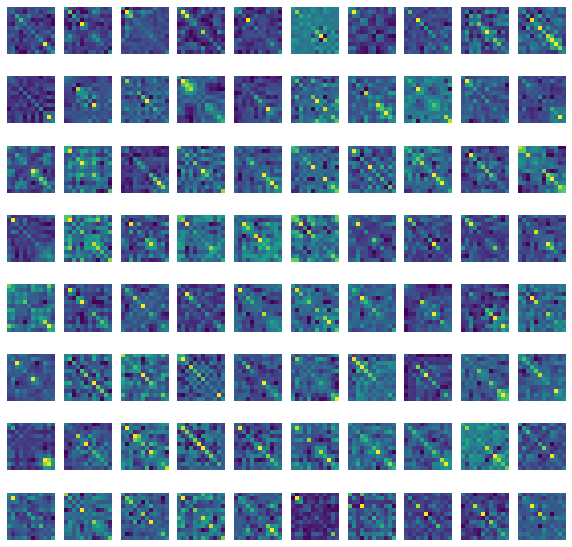

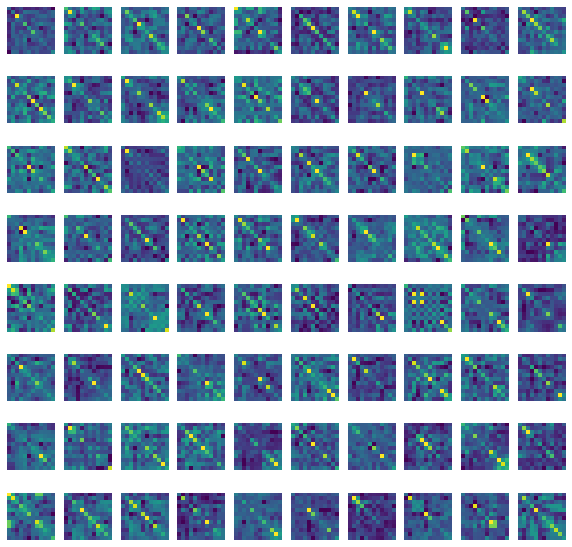

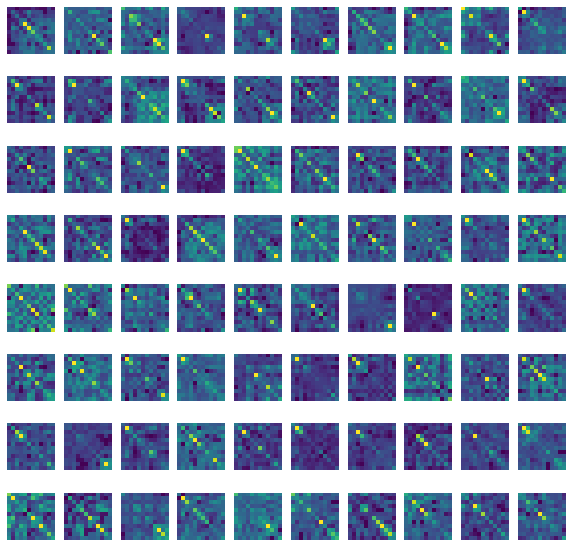

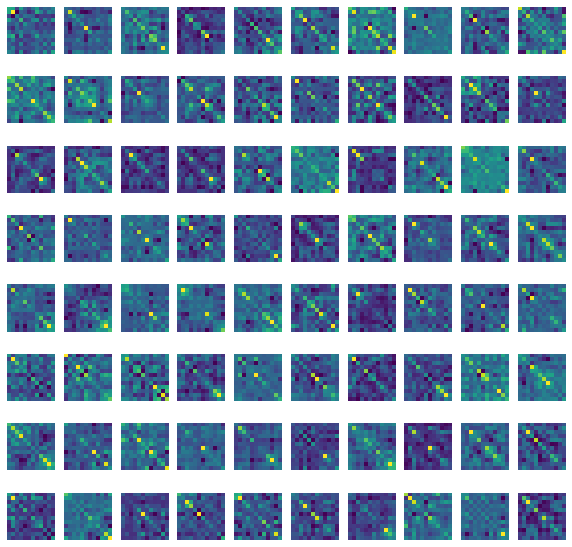

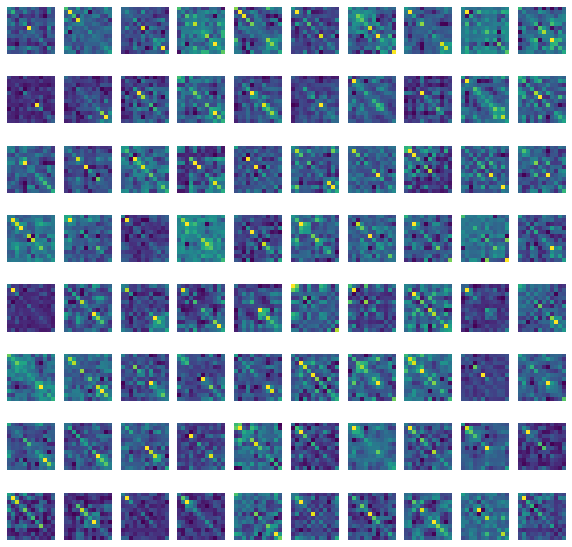

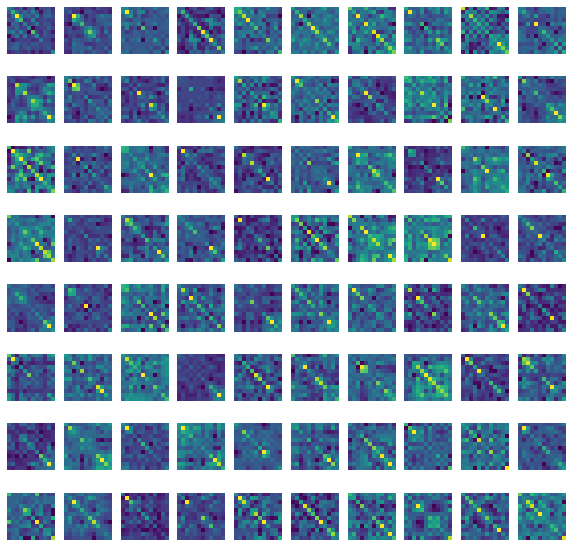

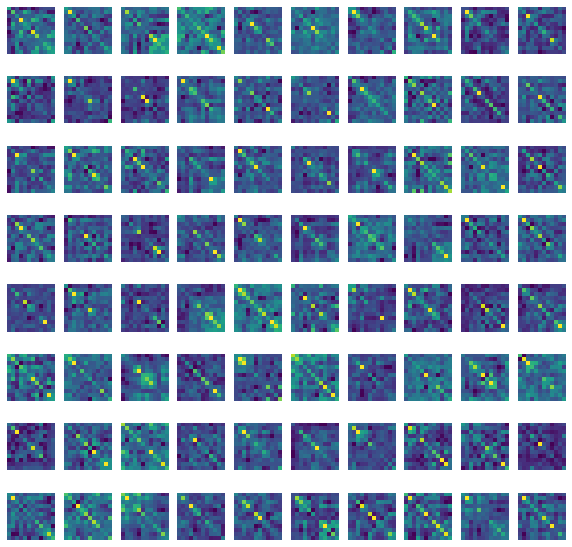

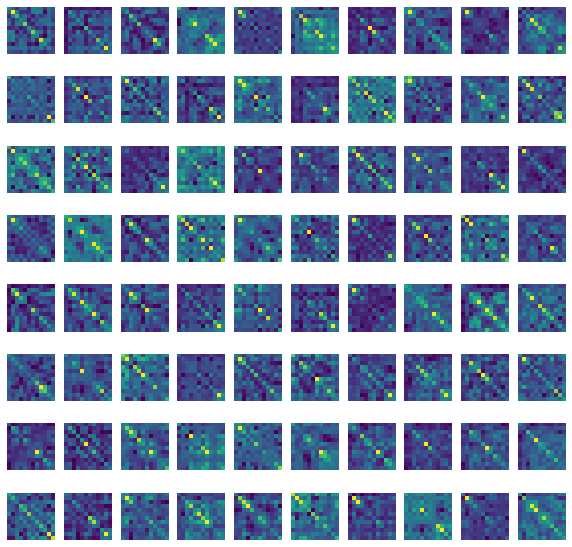

In [36]:
for s in range(8):
    fig, axes = plt.subplots(8, 10, figsize=(10, 10))
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(X_train_all[s][i])
        ax.axis('off')

In [64]:
s = 0
spd = np.array([isPD2(t) for t in X_train_all[s]])
X = X_train_all[s][spd]
y = y_train_all[s][spd]
le = LabelEncoder()
y = le.fit_transform(y)
#fig, axes = plt.subplots(8, 10, figsize=(10, 10))
#for i, ax in enumerate(axes.flatten()):
#    ax.imshow(X[i])
#    ax.axis('off')
MDM(metric='logeuclid', n_jobs=1).fit(X, y)

MDM(metric='logeuclid', n_jobs=1)

In [68]:
cv = LeaveOneOut()
all_res = []
subjects = range(8)
for s in tqdm(subjects):
    print ("Sujet {}".format(s+1))
    spd = np.array([isPD2(t) for t in X_train_all[s]])
    X = X_train_all[s][spd]
    y = y_train_all[s][spd]
    le = LabelEncoder()
    y = le.fit_transform(y)

    for name in tqdm(pipelines):
        print(name)
        acc = cross_val_score(pipelines[name], X, y, cv=cv, scoring=scoring)
        res = {'subject': str(s+1),
               'score': np.nanmean(acc),
               'estimator': "AEC",
               'samples' : len(X),
               'pipeline': name}
        all_res.append(res)
df_aec = pd.DataFrame(all_res)

Sujet 1


MDM
0.5875 [0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 1.
 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1.
 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 1. 1. 0.
 0. 1. 1. 1. 1. 1. 0. 1.]

Sujet 2


MDM


/home/sylchev/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Covariance matrices must be positive definite. Add regularization to avoid this error.

  FitFailedWarning)


nan [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan  1. nan nan nan nan nan]

Sujet 3


MDM
0.4810126582278481 [1. 1. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0.
 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1.
 1. 1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1.
 0. 1. 1. 1. 1. 0. 0.]

Sujet 4


MDM
0.5 [1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1.
 0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1. 0.
 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0.
 0. 1. 0. 1. 0. 1. 1. 1.]

Sujet 5


MDM
0.45 [0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 1. 0. 1. 0. 1. 1. 0. 1. 1.
 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 1. 0.
 1. 1. 0. 1. 0. 0. 0. 1.]

Sujet 6


MDM
0.569620253164557 [1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0.
 1. 0. 0. 1. 0. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0.
 0. 0. 1. 1. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 1.
 1. 0. 0. 1. 0. 1. 1.]

Sujet 7


MDM
0.4810126582278481 [0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 1. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1.
 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1.
 1. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 1.
 1. 0. 1. 0. 1. 1. 0.]

Sujet 8


MDM
nan [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan]




In [69]:
df_aec

,subject,score,estimator,samples,pipeline
0,1,0.587500,AEC,80,MDM
1,2,NaN,AEC,80,MDM
2,3,0.481013,AEC,79,MDM
3,4,0.500000,AEC,80,MDM
4,5,0.450000,AEC,80,MDM
5,6,0.569620,AEC,79,MDM
6,7,0.481013,AEC,79,MDM
7,8,NaN,AEC,80,MDM


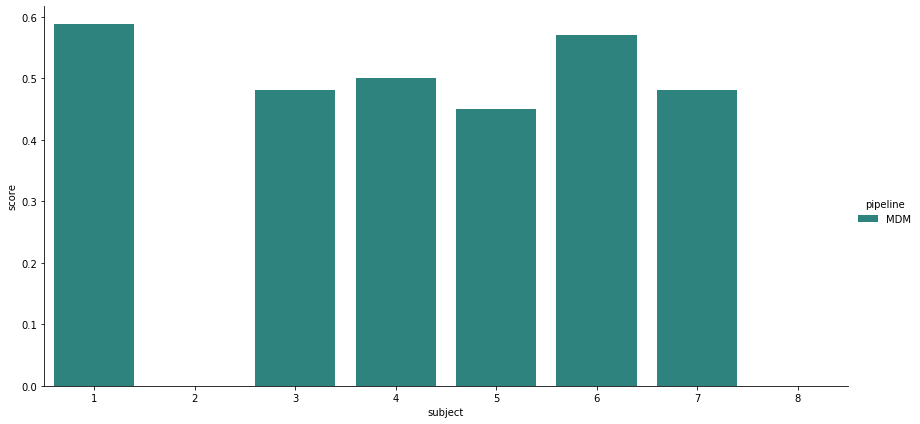

In [70]:
sns.catplot(x='subject', y='score', hue='pipeline', kind='bar', data=df_aec, height=6, aspect=2, palette="viridis")
plt.savefig("aec-subject.png")

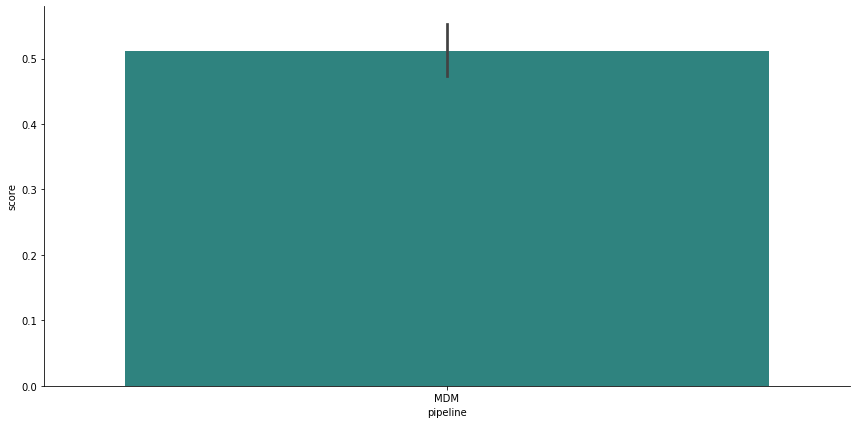

In [71]:
sns.catplot(x='pipeline', y='score', kind='bar', data=df_aec, height=6, aspect=2, palette="viridis")
plt.savefig("aec-classif.png")

# Spectral Coherence

In [79]:
d = loadmat("AlphaBetaTogether/Coh_Training_All.mat", squeeze_me=True)

In [80]:
X_train_all = []
y_train_all = []
for i in range(0, 8):
    v = d['MatCoh'][i, 0]
    y_train = d['MatCoh'][i, 1]
    X_train = []
    for s in range(80):
        X = np.zeros((12, 12))
        X[np.triu_indices(12, 0)] = v[:, s]
        X = X+X.T
        X_train.append(X)
    X_train_all.append(np.array(X_train))
    y_train_all.append(y_train)

In [81]:
for s in range(8):
    spd = []
    for i in range(80):
        spd.append(isPD2(X_train_all[s][i]))
    print("Sur 80 trials, {} sont SPD".format(np.array(spd).sum()))
for s in range(8):
    for i in range(80):
        if not isPD2(X_train_all[s][i]):
            X_train_all[s][i] = nearestPD(X_train_all[s][i])
print ("après régularisation : ")
for s in range(8):
    spd = []
    for i in range(80):
        spd.append(isPD2(X_train_all[s][i]))
    print("Sur 80 trials, {} sont SPD".format(np.array(spd).sum()))

Sur 80 trials, 1 sont SPD
Sur 80 trials, 1 sont SPD
Sur 80 trials, 5 sont SPD
Sur 80 trials, 0 sont SPD
Sur 80 trials, 1 sont SPD
Sur 80 trials, 3 sont SPD
Sur 80 trials, 9 sont SPD
Sur 80 trials, 0 sont SPD
après régularisation : 
Sur 80 trials, 79 sont SPD
Sur 80 trials, 77 sont SPD
Sur 80 trials, 76 sont SPD
Sur 80 trials, 79 sont SPD
Sur 80 trials, 77 sont SPD
Sur 80 trials, 76 sont SPD
Sur 80 trials, 74 sont SPD
Sur 80 trials, 76 sont SPD


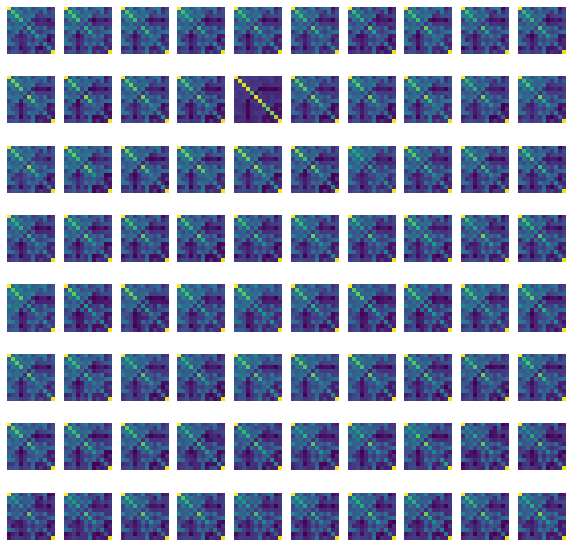

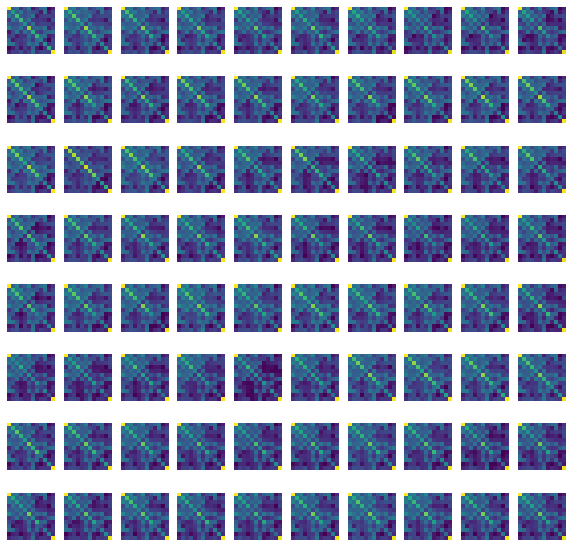

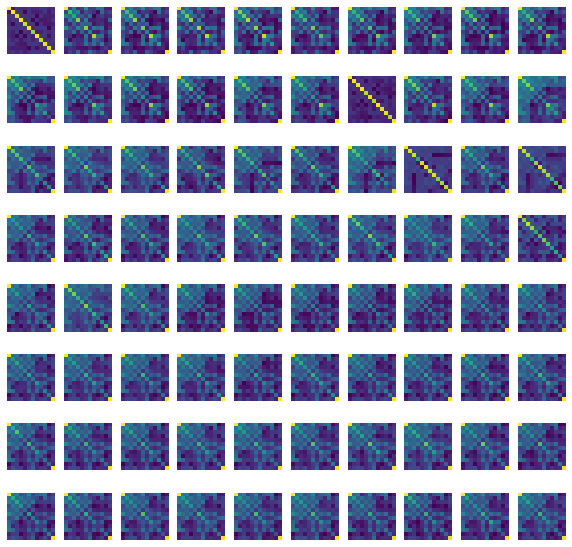

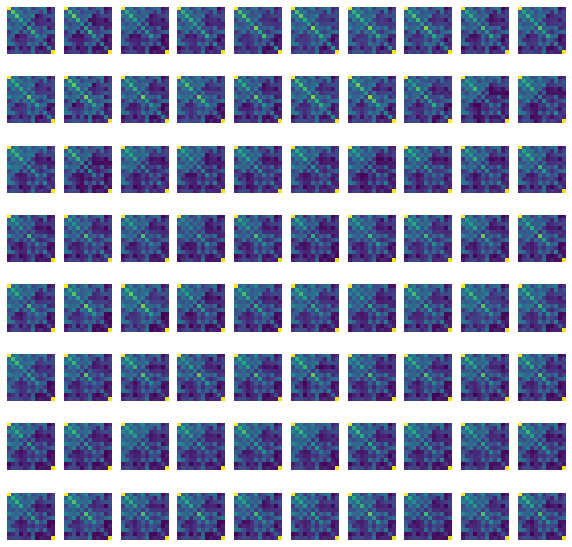

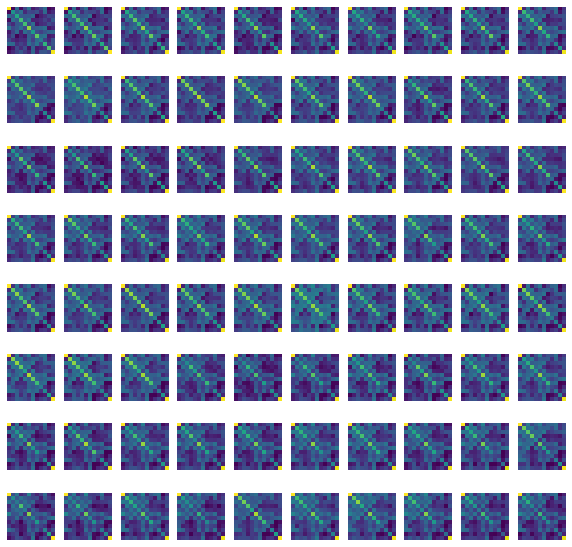

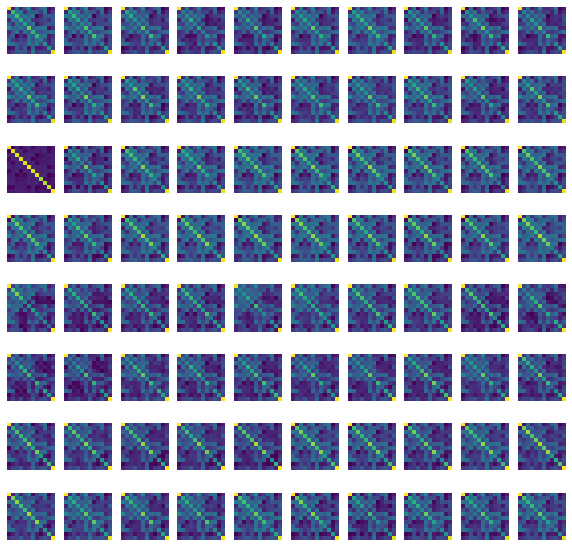

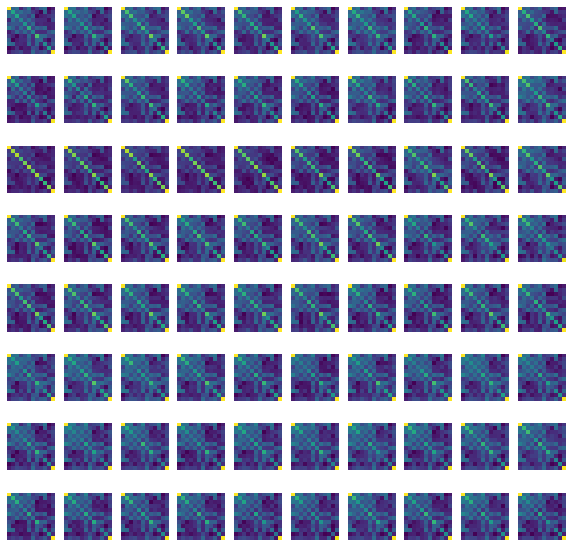

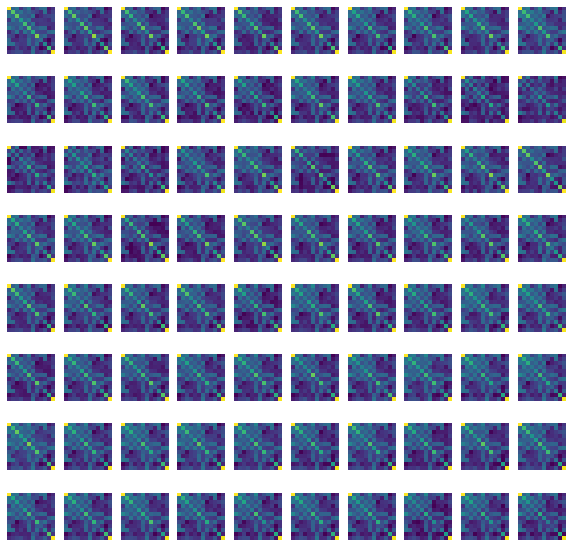

In [101]:
for s in range(8):
    fig, axes = plt.subplots(8, 10, figsize=(10, 10))
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(X_train_all[s][i])
        ax.axis('off')

In [84]:
cv = LeaveOneOut()
all_res = []
subjects = range(8)
for s in tqdm(subjects):
    print ("Sujet {}".format(s+1))
    spd = np.array([isPD2(t) for t in X_train_all[s]])
    X = X_train_all[s][spd]
    y = y_train_all[s][spd]
    le = LabelEncoder()
    y = le.fit_transform(y)

    for name in tqdm(pipelines):
        acc = cross_val_score(pipelines[name], X, y, cv=cv, scoring=scoring)
        res = {'subject': str(s+1),
               'score': np.nanmean(acc),
               'estimator': "Coh",
               'pipeline': name}
        all_res.append(res)
df_coh = pd.DataFrame(all_res)

Sujet 1


/home/sylchev/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Covariance matrices must be positive definite. Add regularization to avoid this error.

  FitFailedWarning)



Sujet 2


/home/sylchev/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice
  from ipykernel import kernelapp as app



Sujet 3



Sujet 4



Sujet 5



Sujet 6



Sujet 7



Sujet 8


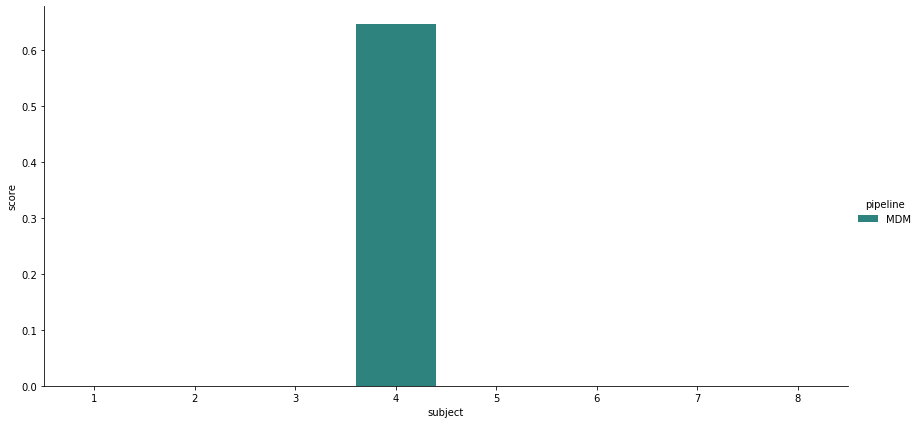

In [85]:
sns.catplot(x='subject', y='score', hue='pipeline', kind='bar', data=df_coh, height=6, aspect=2, palette="viridis")
plt.savefig("coh-subject.png")

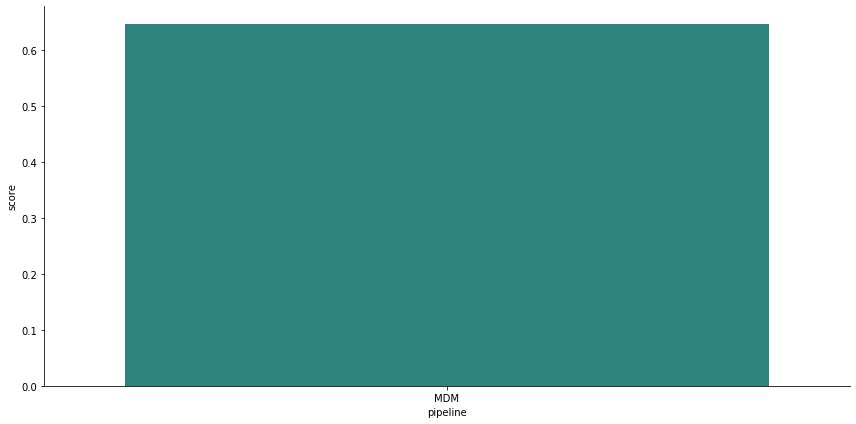

In [86]:
sns.catplot(x='pipeline', y='score', kind='bar', data=df_coh, height=6, aspect=2, palette="viridis")
plt.savefig("coh-classif.png")

# Imaginary coherence

In [87]:
d = loadmat("AlphaBetaTogether/ICoh_Training_All.mat", squeeze_me=True)

In [88]:
d['MatICoh'][0, 0].shape

(78, 80)

In [89]:
X_train_all = []
y_train_all = []
for i in range(0, 8):
    v = d['MatICoh'][i, 0]
    y_train = d['MatICoh'][i, 1]
    X_train = []
    for s in range(80):
        X = np.zeros((12, 12))
        X[np.triu_indices(12, 0)] = v[:, s]
        X = X+X.T
        X_train.append(X)
    X_train_all.append(np.array(X_train))
    y_train_all.append(y_train)

In [90]:
for s in range(8):
    spd = []
    for i in range(80):
        spd.append(isPD2(X_train_all[s][i]))
    print("Sur 80 trials, {} sont SPD".format(np.array(spd).sum()))
for s in range(8):
    for i in range(80):
        if not isPD2(X_train_all[s][i]):
            X_train_all[s][i] = nearestPD(X_train_all[s][i])
print ("après régularisation : ")
for s in range(8):
    spd = []
    for i in range(80):
        spd.append(isPD2(X_train_all[s][i]))
    print("Sur 80 trials, {} sont SPD".format(np.array(spd).sum()))

Sur 80 trials, 0 sont SPD
Sur 80 trials, 0 sont SPD
Sur 80 trials, 0 sont SPD
Sur 80 trials, 0 sont SPD
Sur 80 trials, 0 sont SPD
Sur 80 trials, 0 sont SPD
Sur 80 trials, 0 sont SPD
Sur 80 trials, 0 sont SPD
après régularisation : 
Sur 80 trials, 79 sont SPD
Sur 80 trials, 77 sont SPD
Sur 80 trials, 80 sont SPD
Sur 80 trials, 80 sont SPD
Sur 80 trials, 79 sont SPD
Sur 80 trials, 80 sont SPD
Sur 80 trials, 78 sont SPD
Sur 80 trials, 79 sont SPD


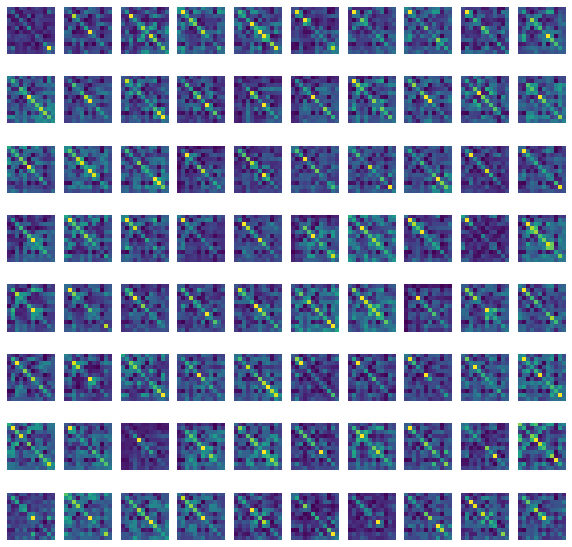

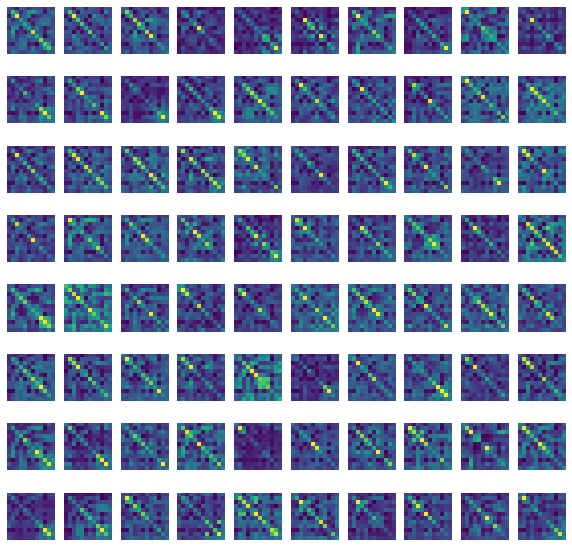

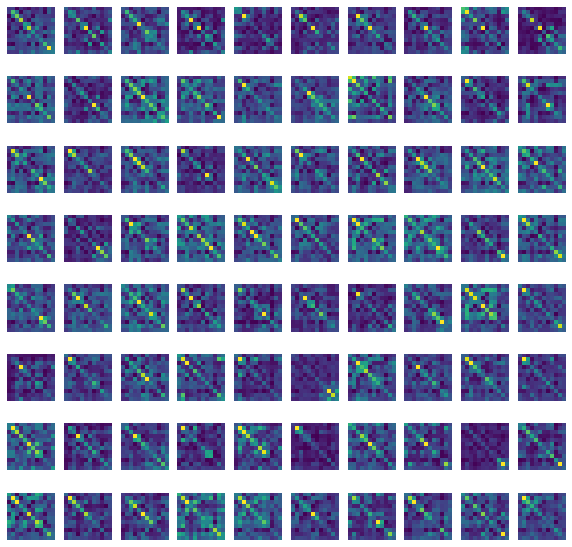

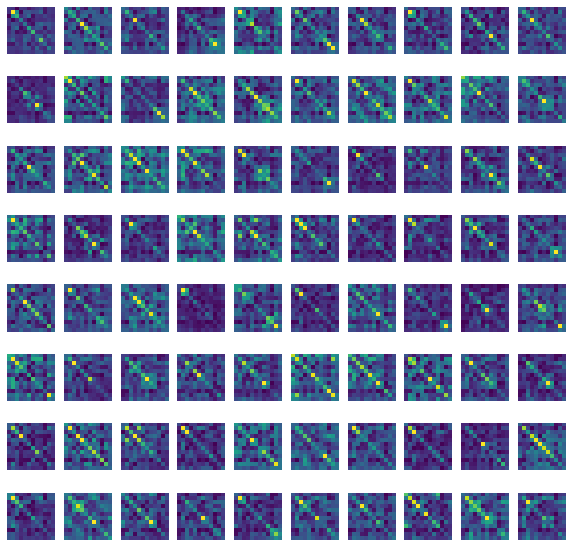

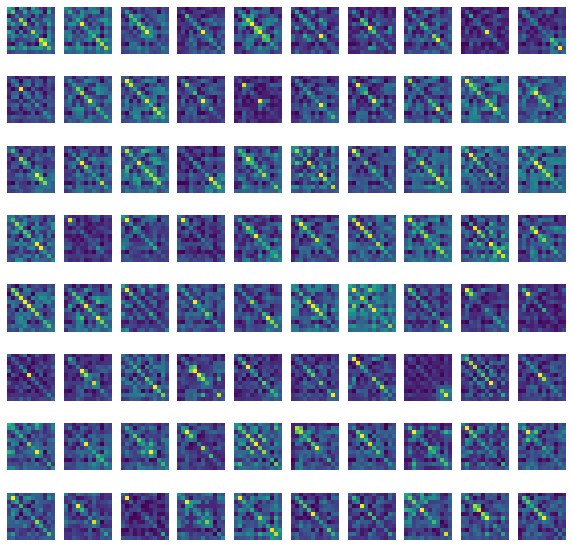

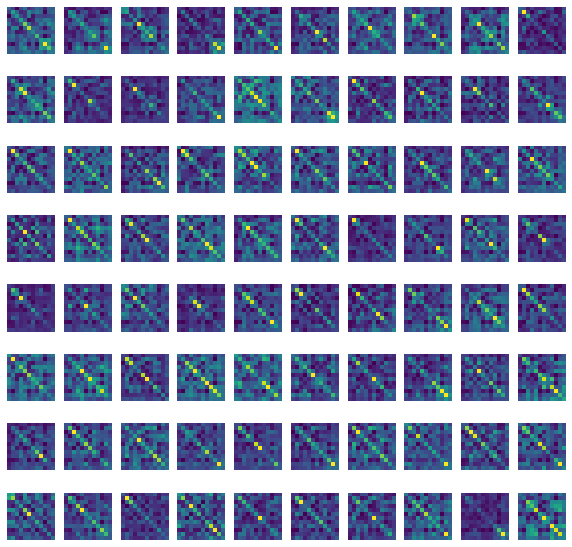

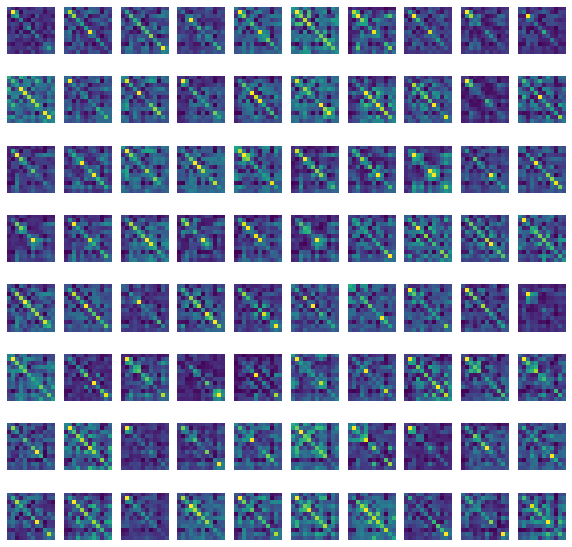

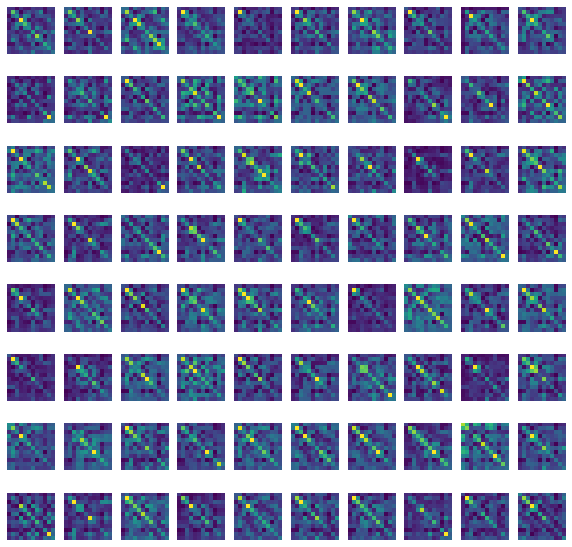

In [91]:
for s in range(8):
    fig, axes = plt.subplots(8, 10, figsize=(10, 10))
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(X_train_all[s][i])
        ax.axis('off')

In [92]:
cv = LeaveOneOut()
all_res = []
subjects = range(8)
for s in tqdm(subjects):
    print ("Sujet {}".format(s+1))
    spd = np.array([isPD2(t) for t in X_train_all[s]])
    X = X_train_all[s][spd]
    y = y_train_all[s][spd]
    le = LabelEncoder()
    y = le.fit_transform(y)

    for name in tqdm(pipelines):
        acc = cross_val_score(pipelines[name], X, y, cv=cv, scoring=scoring)
        res = {'subject': str(s+1),
               'score': np.nanmean(acc),
               'estimator': "ICoh",
               'pipeline': name}
        all_res.append(res)
df_icoh = pd.DataFrame(all_res)

Sujet 1


/home/sylchev/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Covariance matrices must be positive definite. Add regularization to avoid this error.

  FitFailedWarning)



Sujet 2



Sujet 3



Sujet 4



Sujet 5


/home/sylchev/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice
  from ipykernel import kernelapp as app



Sujet 6



Sujet 7



Sujet 8


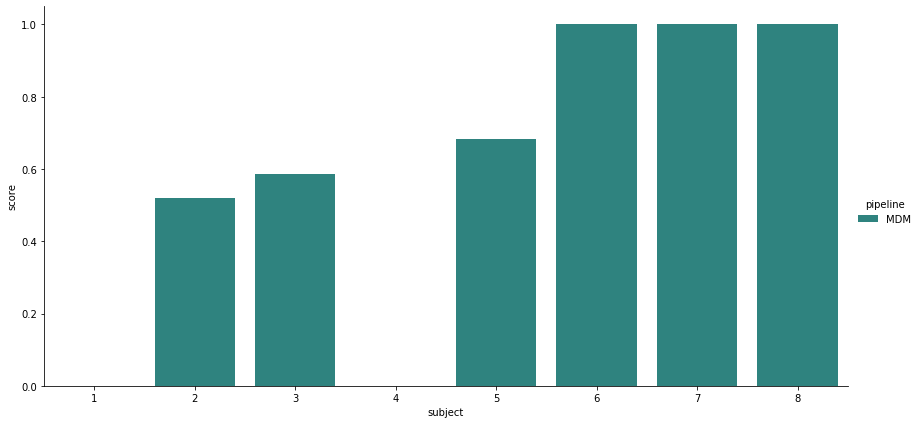

In [93]:
sns.catplot(x='subject', y='score', hue='pipeline', kind='bar', data=df_icoh, height=6, aspect=2, palette="viridis")
plt.savefig("icoh-subject.png")

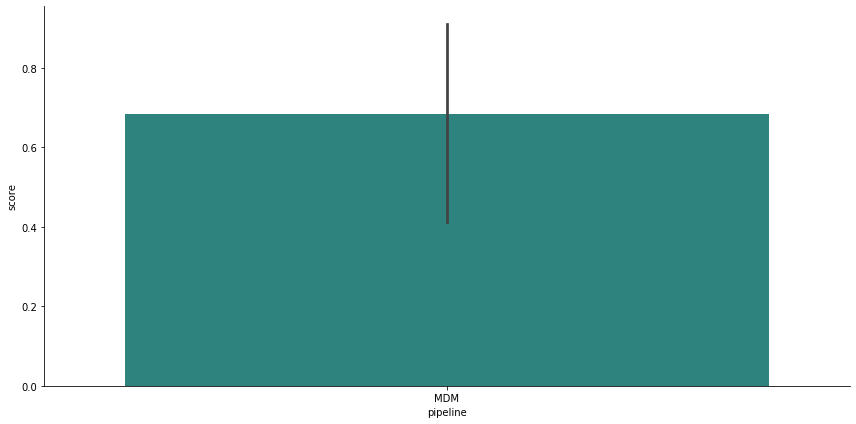

In [94]:
sns.catplot(x='pipeline', y='score', kind='bar', data=df_icoh, height=6, aspect=2, palette="viridis")
plt.savefig("icoh-classif.png")

# Phase Lock Value

In [95]:
d = loadmat("AlphaBetaTogether/PLV_Training_All.mat", squeeze_me=True)
#d = loadmat("OLD/PLV_Training.mat", squeeze_me=True)

In [96]:
# for i in range(8): print (d["MatPLV"][i, 0].shape)
d["MatPLV"][i, 0][:,0], d["MatPLV"][i, 0][:, 80]

IndexError: index 79 is out of bounds for axis 0 with size 8

In [ ]:
X_train_all = []
y_train_all = []
for i in range(0, 8):
    v = d['MatPLV'][i, 0]
    y_train = d['MatPLV'][i, 1]
    X_train = []
    for s in range(80):
        X = np.zeros((12, 12))
        X[np.triu_indices(12, 0)] = v[:, s]
        X = X+X.T
        X_train.append(X)
    X_train_all.append(np.array(X_train))
    y_train_all.append(y_train)

In [ ]:
for s in range(8):
    spd = []
    for i in range(80):
        spd.append(isPD2(X_train_all[s][i]))
    print("Sur 80 trials, {} sont SPD".format(np.array(spd).sum()))
for s in range(8):
    for i in range(80):
        if not isPD2(X_train_all[s][i]):
            X_train_all[s][i] = nearestPD(X_train_all[s][i])
print ("après régularisation : ")
for s in range(8):
    spd = []
    for i in range(80):
        spd.append(isPD2(X_train_all[s][i]))
    print("Sur 80 trials, {} sont SPD".format(np.array(spd).sum()))

In [ ]:
for s in range(8):
    fig, axes = plt.subplots(8, 10, figsize=(10, 10))
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(X_train_all[s][i])
        ax.axis('off')

In [ ]:
cv = LeaveOneOut()
all_res = []
subjects = range(8)
for s in tqdm(subjects):
    print ("Sujet {}".format(s+1))
    spd = np.array([isPD2(t) for t in X_train_all[s]])
    X = X_train_all[s][spd]
    y = y_train_all[s][spd]
    le = LabelEncoder()
    y = le.fit_transform(y)

    for name in tqdm(pipelines):
        acc = cross_val_score(pipelines[name], X, y, cv=cv, scoring=scoring)
        res = {'subject': str(s+1),
               'score': np.mean(acc),
               'estimator': "PLV",
               'pipeline': name}
        all_res.append(res)
df_plv = pd.DataFrame(all_res)

In [ ]:
sns.catplot(x='subject', y='score', hue='pipeline', kind='bar', data=df_plv, height=6, aspect=2, palette="viridis")
plt.savefig("plv-subject.png")

In [ ]:
sns.catplot(x='pipeline', y='score', kind='bar', data=df_plv, height=6, aspect=2, palette="viridis")
plt.savefig("plv-classif.png")